In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
from monk import Dataset, PredictorPipe, cfg_static_default, cfg_inference_default, Image
from monk.inference.wrappers import (
    Centermask2InstanceWrapper,
    DeeplabSemanticWrapper,
    Detectron2InstanceWrapper,
    Fastai2Classification,
    InstanceWrapper,
    SemanticWrapper,
    Wrapper,
    Yolov5InstanceWrapper,
)
import numpy as np
import torch

from monk.config.default import PipelineInferenceConfig, PipelineStaticConfig
from monk.inference.prediction import (
    PredictionBrandModel,
    PredictionImageType,
    PredictionInstance,
    PredictionSemantic,
    PredictionViewpoint,
)
from monk.utils.extend_boxes import preprocess_bbox



from monk.evaluation.evaluators.damage_detection import BBoxDamageDetection, DamageDetection
from monk.evaluation.evaluators.instance2sem import Instance2SemEvaluator
from monk.evaluation import EvaluatorRoutine

from monk import Masks
from monk import Mask
from monk import BBox

import joblib
import os
import matplotlib.pyplot as plt
import reload
import cv2
import tensorflow_addons as tfa

In [3]:
import tensorflow as tf
import numpy as np

In [13]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
from augmenter import CustomAugment

# Damaged

In [ ]:
path ='/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea'
parts_ds= []
dam_ds =[]
for d in os.listdir(path):
    if 'parts' in d:
        parts_ds.append(d)
    else:
        dam_ds.append(d)
        
path_damaged = path+'/'+dam_ds[0]

In [ ]:
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"]   
gen = get_damaged_generator(path_damaged, batch_size=3, dim=(128,128), to_keep=to_keep)



In [ ]:
r = gen.__getitem__(9)
print(r.shape)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(r[0])
plt.subplot(1,3,2)
plt.imshow(r[1])
plt.subplot(1,3,3)
plt.imshow(r[2])

# Non damaged

In [ ]:
path_non_damaged = '/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_train.json'
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"]    

In [ ]:
gen = get_non_damaged_generator(path_non_damaged, batch_size=3, dim=(128,128), to_keep=to_keep)

In [ ]:
r = gen.__getitem__(9)
print(r.shape)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(r[0])
plt.subplot(1,3,2)
plt.imshow(r[1])
plt.subplot(1,3,3)
plt.imshow(r[2])

# MIXED

In [ ]:
path ='/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea'
parts_ds= []
dam_ds =[]
for d in os.listdir(path):
    if 'parts' in d:
        parts_ds.append(d)
    else:
        dam_ds.append(d)
        
path_damaged = path+'/'+dam_ds[0]

path_non_damaged = '/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_train.json'
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"] 

#to_keep='all'

In [ ]:
gen = get_mixed_generator(path_damaged,path_non_damaged, batch_size=3, dim=(228,228), to_keep=to_keep,area_threshold=5000)

In [ ]:
r = gen.__getitem__(np.random.randint(1,1000))
print(r.shape)
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(r[0])
plt.subplot(1,3,2)
plt.imshow(r[1])
plt.subplot(1,3,3)
plt.imshow(r[2])

# Augmentation

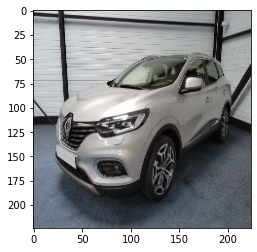

In [73]:
img = cv2.imread('/home/ubuntu/shared/data/auto_ici/images/133408_0067035172fc786488ff7c6317ed88c9.jpg')
img = cv2.resize(img,(224,224))/255
img = np.array(img,dtype=np.float32)
plt.imshow(img)

In [80]:
# Build the augmentation pipeline
data_augmentation = tf.keras.Sequential([tf.keras.layers.Lambda(CustomAugment())])


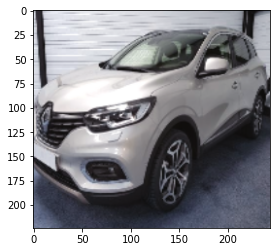

In [85]:
aug = data_augmentation(tf.expand_dims(tf.convert_to_tensor(img),0))
plt.imshow(aug[0])

In [86]:
batch=np.array([img,img])
print(batch.shape)

(2, 224, 224, 3)


In [87]:
aug = data_augmentation(batch)


In [88]:
aug.shape

TensorShape([2, 224, 244, 3])

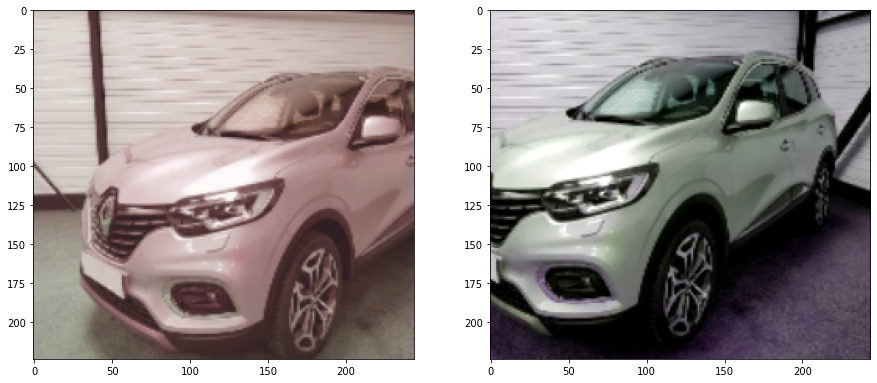

In [92]:
aug = data_augmentation(batch)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(aug[0])
plt.subplot(1,2,2)
plt.imshow(aug[1])